## Importing needed libraries ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Data ##

In [2]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

# Checking for balanced data
data = train_data[train_data['Target'] == 0]
data1 = train_data[train_data['Target'] == 1]
print('The balance of the data is',len(data1)/len(train_data))

# Checking for duplicates 
duplicate_values = train_data['ID'].duplicated()
duplicate_count = duplicate_values.sum()
print(f'Number of duplicates in the train dataset: {duplicate_count}')

# Dropping the ID column as we do not need it for the model training
train_data = train_data.drop(['ID'], axis = 1)

numerical_columns = ['Amount', 'refill_frequency', 'revenue', 'arpu_segment', 'frequency', 'data_volume', 'on_net', 
                     'Procuct_1', 'Procuct_2', 'regularity', 'freq_top_pack', 'zone1', 'zone2']
categorical_columns = ['region', 'tenure', 'mrg', 'top_pack']

The balance of the data is 0.18736478949274257
Number of duplicates in the train dataset: 0


In [3]:
train_data.head()


,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,3,NaN,NaN,0
1,Nebula,K > 24 month,4764.96,41.0,4756.84,1585.47,41.0,2.0,626.0,24.0,NaN,NaN,NaN,NO,62,On net 200F=Unlimited _call24H,31.0,0
2,Celestial,K > 24 month,5769.23,22.0,5769.23,1923.08,22.0,28121.0,0.0,NaN,1.0,NaN,NaN,NO,61,NaN,NaN,0
3,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,6,NaN,NaN,0
4,Eclipsara,K > 24 month,5341.88,58.0,5636.75,1879.06,60.0,1131.0,546.0,376.0,0.0,NaN,NaN,NO,62,Mixt 250F=Unlimited_call24H,31.0,0


## Imputing missing values ##

In [4]:
mean_imputer = SimpleImputer(strategy='mean')

# Imputing missing numerical values with the mean
for col in numerical_columns:
    train_data[[col]] = mean_imputer.fit_transform(train_data[[col]])
    test_data[[col]] = mean_imputer.transform(test_data[[col]]) 

mode_imputer = SimpleImputer(strategy='most_frequent')

# Imputing missing categorical values with the mode
for col in categorical_columns:
    train_data[[col]] = mode_imputer.fit_transform(train_data[[col]])
    test_data[[col]] = mode_imputer.transform(test_data[[col]]) 

## Normalizing numerical variables ##

In [5]:
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Fitting the scaler on the training data and transforming both training and test data
train_data[numerical_columns] = scaler.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = scaler.transform(test_data[numerical_columns])

In [6]:
train_data.head()

,region,tenure,Amount,refill_frequency,revenue,arpu_segment,frequency,data_volume,on_net,Procuct_1,Procuct_2,zone1,zone2,mrg,regularity,top_pack,freq_top_pack,Target
0,Mandalore,K > 24 month,0.018986,0.079708,0.020684,0.020687,0.144085,0.001839,0.005471,0.007917,0.005545,0.001689,0.002375,NO,0.032787,All-net 500F=2000F;5d,0.013159,0
1,Nebula,K > 24 month,0.038349,0.303030,0.041834,0.041834,0.444444,0.000001,0.012321,0.001993,0.005545,0.001689,0.002375,NO,1.000000,On net 200F=Unlimited _call24H,0.047771,0
2,Celestial,K > 24 month,0.046439,0.159091,0.050739,0.050743,0.233333,0.015418,0.000000,0.007917,0.000240,0.001689,0.002375,NO,0.983607,All-net 500F=2000F;5d,0.013159,0
3,Mandalore,K > 24 month,0.018986,0.079708,0.020684,0.020687,0.144085,0.001839,0.005471,0.007917,0.005545,0.001689,0.002375,NO,0.081967,All-net 500F=2000F;5d,0.013159,0
4,Eclipsara,K > 24 month,0.042996,0.431818,0.049574,0.049581,0.655556,0.000620,0.010746,0.031229,0.000000,0.001689,0.002375,NO,1.000000,Mixt 250F=Unlimited_call24H,0.047771,0


## Encoding categorical variables ##

In [7]:
# Initializing OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Applying OneHotEncoder to the categorical columns
encoded_cats = encoder.fit_transform(train_data[categorical_columns])
encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

# Dropping the original categorical columns and concatenating the encoded columns
train_data = train_data.drop(categorical_columns, axis=1)
train_data = pd.concat([train_data, encoded_cats_df], axis=1)


## Splitting the training data ##

In [8]:
X = train_data.drop(['Target'], axis=1)
y = train_data['Target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## Decision Tree ##

In [12]:
# Tuning hyperparameters, finding the best set of hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 10, 25, 100],
    'min_samples_split': [2, 5, 10]
}

# Creating the Decision Tree Classifier
dtree = DecisionTreeClassifier()

# Performing Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Printing the best hyperparameters found
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}


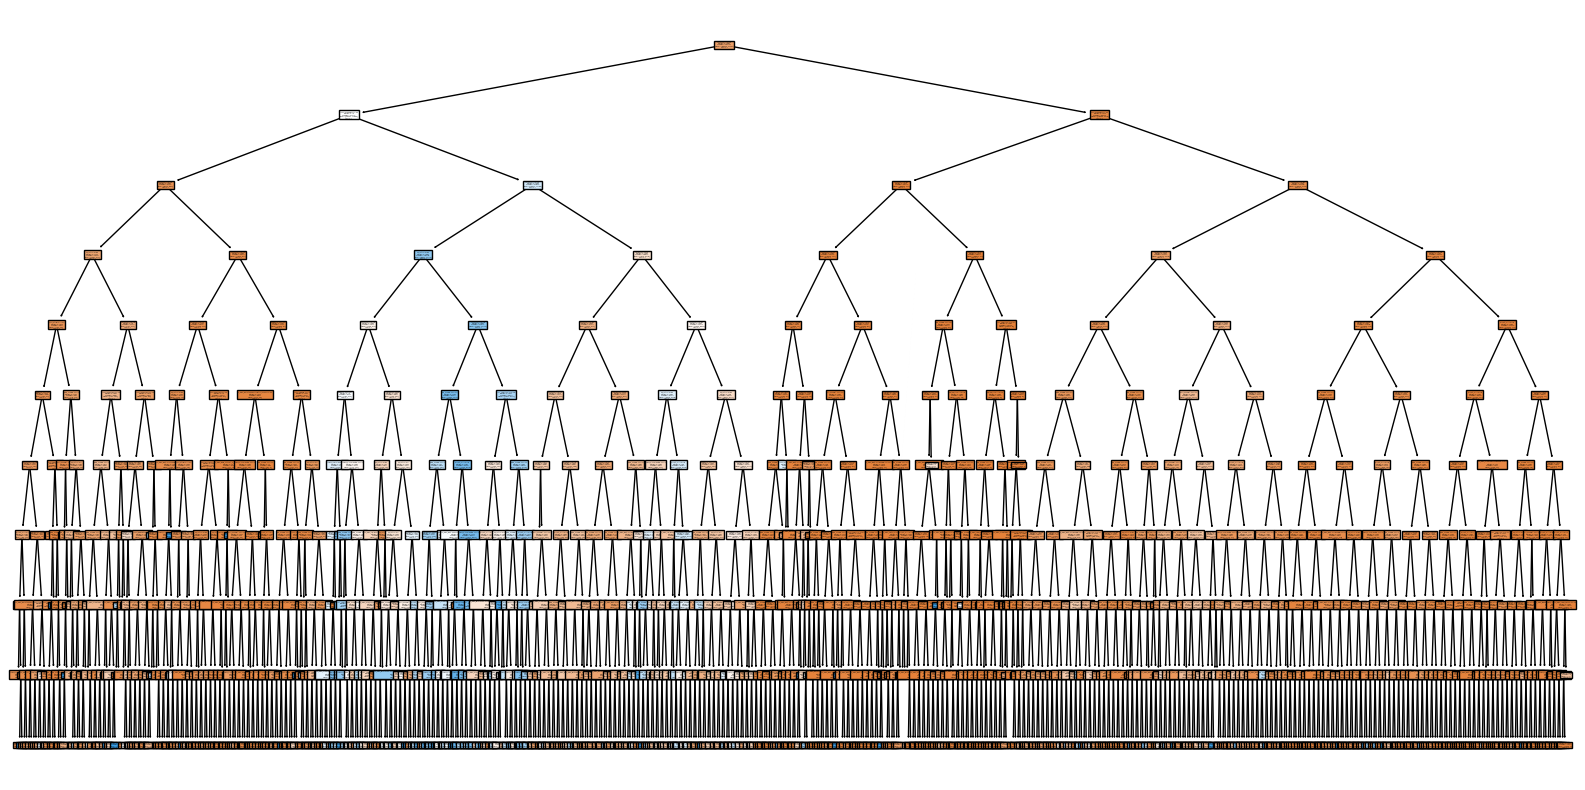

In [9]:
# Training the model with the best combination of hyperparameters
decision_tree = DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, min_samples_split= 10)   # Learner
decision_tree.fit(X_train, y_train) 

# Visualization
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['0', '1'])
plt.show()

## Random Forest ##

In [16]:
# Tuning hyperparameters, finding the best set of hyperparameters
param_forest = {
    'n_estimators': [20, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 25, 50],
    'min_samples_split': [5, 10],
    'min_samples_leaf' : [3, 4],
    }

# Creating the Random Forest 
dforest = RandomForestClassifier(random_state=42)

# Performing RandomizedSearch Cross-Validation
search = RandomizedSearchCV(estimator=dforest, param_distributions=param_forest, n_iter = 48, cv = 5, verbose=2, random_state=42, n_jobs = -1)

search.fit(X_train, y_train)

# Printing the best hyperparameters found
print("Best Hyperparameters: ", search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 50, 'criterion': 'gini'}


In [10]:
# Training the model with the best combination of hyperparameters
random_forest = RandomForestClassifier(n_estimators= 100, criterion= 'gini', max_depth= 50, min_samples_split= 10, min_samples_leaf= 3)   # Learner
random_forest.fit(X_train, y_train) 

RandomForestClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=10)

c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\tree\_export.py:664: UserWarning: Glyph 9 (	) missing from current font.
  ann.update_bbox_position_size(renderer)
c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


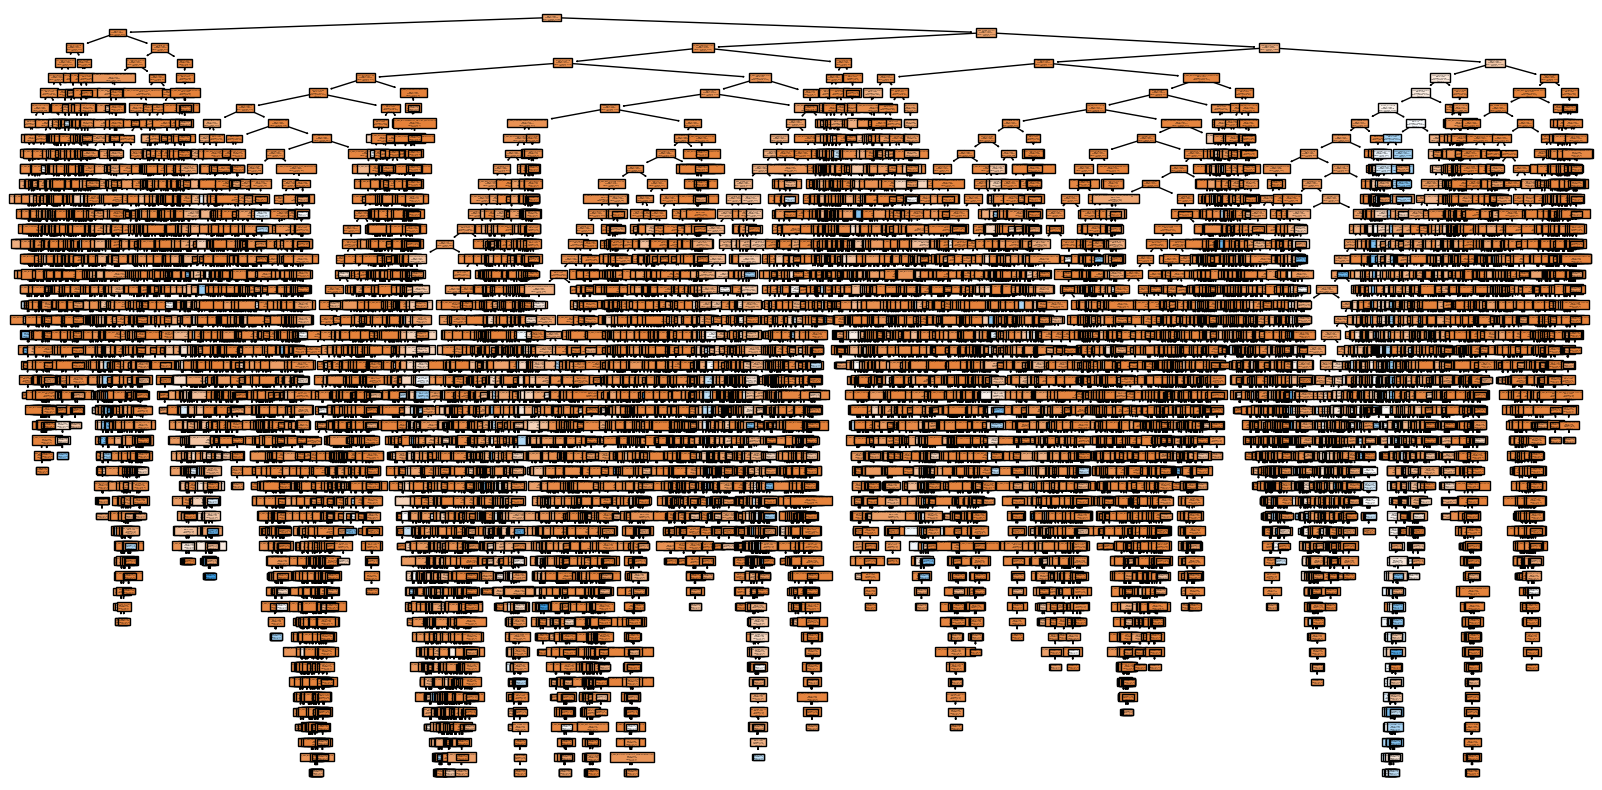

In [60]:
# Visualization of one tree from Random Forest
estimator = random_forest.estimators_[5]  # We can change index to view different trees

plt.figure(figsize=(20,10))
plot_tree(estimator, filled=True, feature_names=X.columns, class_names=['0', '1'])
plt.show()

## Logistic Regression ##

In [11]:
# Initializing the logistic regression model
model = LogisticRegression()

# Defining the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],       # Types of penalty
    'max_iter': [100, 200, 400, 500]   # Max iterations
}

# Initializing RandomizedSearchCV
grid_search = RandomizedSearchCV(model, param_grid, n_iter = 40, cv = 5, verbose=2, random_state=35, n_jobs = -1)

# Fitting RandomizedSearchCV to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)


c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logisti

Best Hyperparameters: {'penalty': 'l2', 'max_iter': 200, 'C': 10}


c:\Users\Lenovo\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# Training the model with the best combination of hyperparameters
logistic_regression = LogisticRegression(C = 10, penalty = 'l2', max_iter = 1000)   # Learner
logistic_regression.fit(X_train, y_train) 

LogisticRegression(C=10, max_iter=1000)

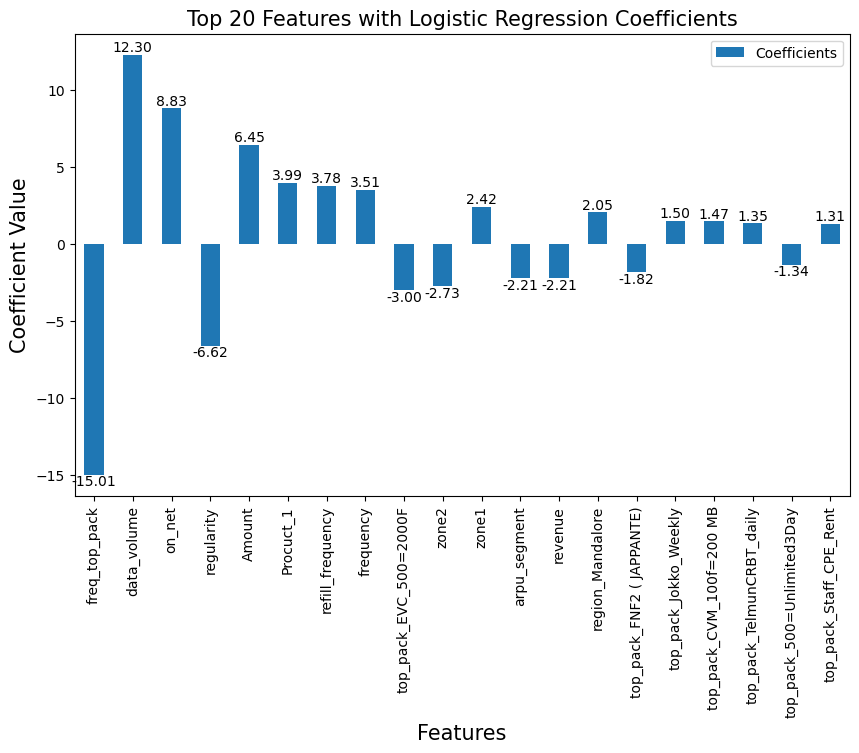

In [20]:
# Visualization of Logistic Regression(top 20)
coef = pd.DataFrame(logistic_regression.coef_[0], index=X.columns, columns=['Coefficients'])
top_n = coef.reindex(coef.abs().nlargest(20, 'Coefficients').index)

# Plot
top_n.plot(kind='bar', figsize=(10, 6))
for idx, value in enumerate(top_n['Coefficients']):
    position = value + 0.01 if value > 0 else value - 0.01
    plt.text(idx, position, f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top')
plt.title('Top 20 Features with Logistic Regression Coefficients', fontsize = 15)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Coefficient Value', fontsize = 15)
plt.show()

## Predicting and evaluating the accuracy ##

In [22]:
# Predicting on the validation set
y_pred_decision_tree = decision_tree.predict(X_val)
y_pred_random_forest = random_forest.predict(X_val)
y_pred_logistic_regression = logistic_regression.predict(X_val)

# Evaluating the models using classification report
# Decision Tree
print("Classification Report for Decision Tree:\n", classification_report(y_val, y_pred_decision_tree))

# Random Forest
print("Classification Report for Random Forest:\n", classification_report(y_val, y_pred_random_forest))

# Logistic Regression
print("Classification Report for Logistic Regression:\n", classification_report(y_val, y_pred_logistic_regression))

Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92    245299
           1       0.68      0.60      0.64     56268

    accuracy                           0.87    301567
   macro avg       0.80      0.77      0.78    301567
weighted avg       0.87      0.87      0.87    301567

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92    245299
           1       0.69      0.58      0.63     56268

    accuracy                           0.87    301567
   macro avg       0.80      0.76      0.78    301567
weighted avg       0.87      0.87      0.87    301567

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92    245299
           1       0.64      0.69      0.66     56268

    accuracy                           0.87    301

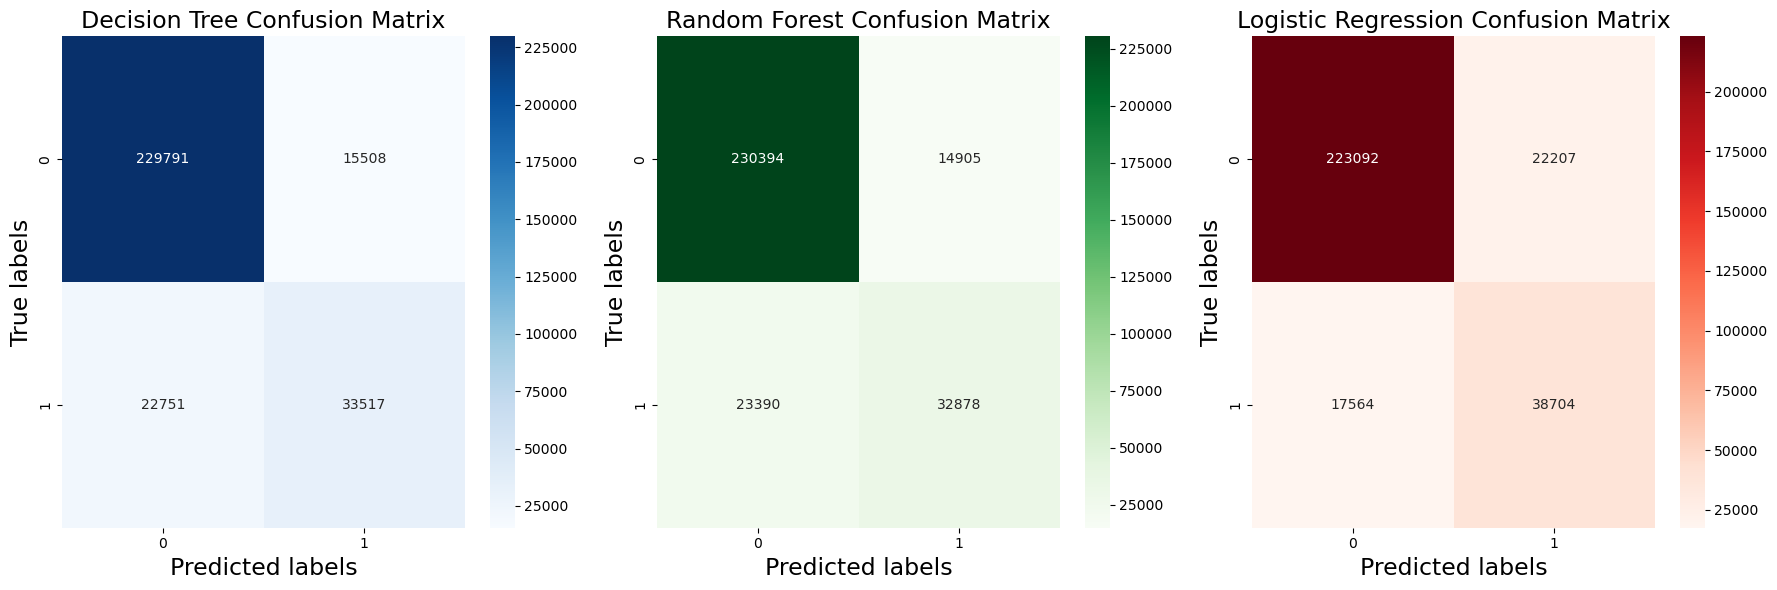

In [19]:
# Evaluating the models using confusion matrix
cm_decision_tree = confusion_matrix(y_val, y_pred_decision_tree)
cm_random_forest = confusion_matrix(y_val, y_pred_random_forest)
cm_logistic_regression = confusion_matrix(y_val, y_pred_logistic_regression)
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Decision Tree
sns.heatmap(cm_decision_tree, annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title('Decision Tree Confusion Matrix', fontsize = 17)
axes[0].set_xlabel('Predicted labels', fontsize = 17)
axes[0].set_ylabel('True labels', fontsize = 17)

# Random Forest
sns.heatmap(cm_random_forest, annot=True, fmt="d", ax=axes[1], cmap="Greens")
axes[1].set_title('Random Forest Confusion Matrix', fontsize = 17)
axes[1].set_xlabel('Predicted labels', fontsize = 17)
axes[1].set_ylabel('True labels', fontsize = 17)

# Logistic Regression
sns.heatmap(cm_logistic_regression, annot=True, fmt="d", ax=axes[2], cmap="Reds")
axes[2].set_title('Logistic Regression Confusion Matrix', fontsize = 17)
axes[2].set_xlabel('Predicted labels', fontsize = 17)
axes[2].set_ylabel('True labels', fontsize = 17)

# Display the heatmap
plt.tight_layout()
plt.show()

## Predicting for test data ##

In [99]:
# Encoding categorical variables
encoded_cats_test = encoder.transform(test_data[categorical_columns])
encoded_cats_test_df = pd.DataFrame(encoded_cats_test, columns=encoder.get_feature_names_out())

# Droping the original categorical columns and concatenating the encoded columns
test_data = test_data.drop(categorical_columns, axis=1)
test_data = pd.concat([test_data, encoded_cats_test_df], axis=1)


In [100]:
# Dropping 'ID' column for applying the model
test_ids = test_data['ID']
X_test = test_data.drop('ID', axis=1)

predictions = logistic_regression.predict(X_test)

# Combining predictions with 'ID' column
result = pd.DataFrame({'ID': test_ids, 'Predictions': predictions})

In [101]:
# Saving test predictions to a CSV file
result.to_csv('test_predictions.csv', index=False)